In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

In [2]:
data_dir_path = '/home/evankielley/IceDEF/data/'

data_fnames = [fname for fname in os.listdir(
    data_dir_path) if fname.endswith('csv') and fname.startswith('0')]

data_fname = data_fnames[0]

In [3]:
def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

In [4]:
def get_day_idxs(dft, day_inc = 5):

    day_idxs = []
    day_js = []
    day_j = 0
    
    for i in range(len(df)):
        day = (dft[i] - dft[0]).days
        if day == day_j:
            day_idxs.append(i)
            day_js.append(day_j)
            day_j += day_inc
    
    return day_idxs, day_js

In [5]:
def plot_drift_track(df, data_fname):
    
    fig = plt.figure()

    x, y = df['Longitude'], df['Latitude']
    
    plt.scatter(x, y, s=2)
    
    t = df['DataDate_UTC']
    day_idxs, day_js = get_day_idxs(t)
    
    for i, day_idx in enumerate(day_idxs):
    
        plt.text(x[day_idx], y[day_idx], str(day_js[i]), fontsize=16, )
    
    plt.title(f'Drift Track from {data_fname}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig

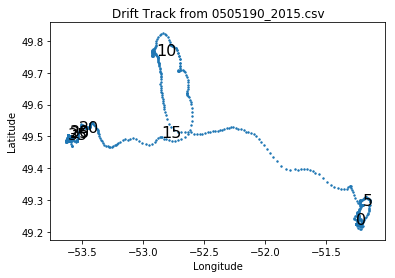

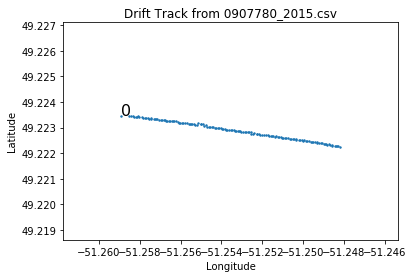

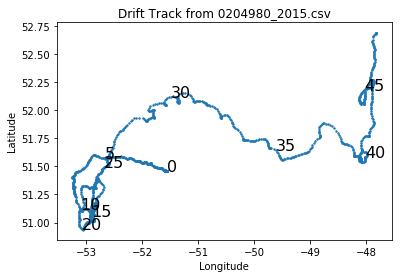

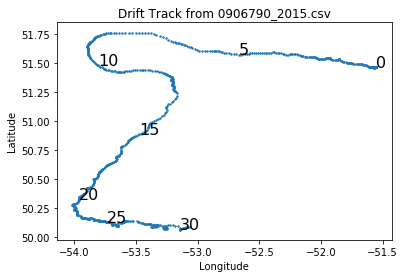

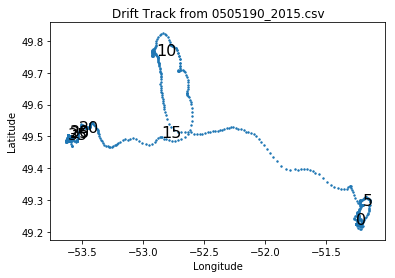

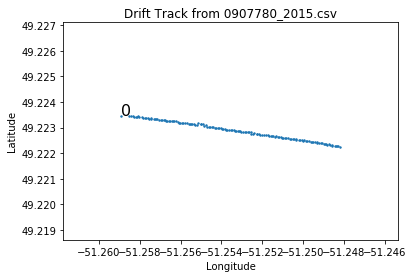

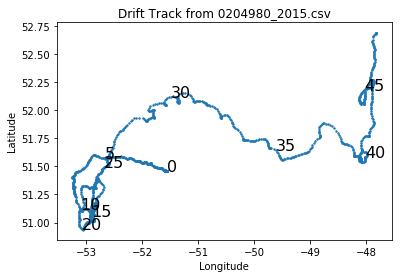

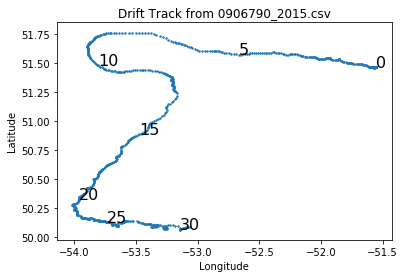

In [9]:
try:
    os.makedirs('plots')
except:
    pass

with PdfPages('plots/beacon_tracks.pdf') as pdf:
    for data_fname in data_fnames:
        df = get_df(data_dir_path, data_fname)
        fig = plot_drift_track(df, data_fname)
        plt.show()
        plt.close()
        pdf.savefig(fig)
        


In [10]:
from icedef import iceberg

In [ ]:
iceberg.get_iip_berg_df()